## Observations and Insights 

In [155]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy import stats
import numpy as np
import statsmodels.api as sm
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)






In [156]:
mouse_metadata.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g)
0,k403,Ramicane,Male,21,16
1,s185,Capomulin,Female,3,17
2,x401,Capomulin,Female,16,15
3,m601,Capomulin,Male,22,17
4,g791,Ramicane,Male,11,16


In [157]:
study_results.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.0,0
1,f932,0,45.0,0
2,g107,0,45.0,0
3,a457,0,45.0,0
4,c819,0,45.0,0


In [158]:
# Combine the data into a single dataset
# Display the data table for preview
merge_df=pd.merge(study_results,mouse_metadata,on="Mouse ID",how ='left')
merge_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,f932,0,45.000000,0,Ketapril,Male,15,29
2,g107,0,45.000000,0,Ketapril,Female,2,29
3,a457,0,45.000000,0,Ketapril,Female,11,30
4,c819,0,45.000000,0,Ketapril,Male,21,25
...,...,...,...,...,...,...,...,...
1888,r944,45,41.581521,2,Capomulin,Male,12,25
1889,u364,45,31.023923,3,Capomulin,Male,18,17
1890,p438,45,61.433892,1,Ceftamin,Female,11,26
1891,x773,45,58.634971,4,Placebo,Female,21,30


In [159]:
# Checking the number of mice.
merge_df['Mouse ID'].nunique()

249

In [160]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 

merge_df["MouseID_Timepoint"] = merge_df['Mouse ID'] + "_" + merge_df['Timepoint'].astype(str)
dedup = merge_df['MouseID_Timepoint'].value_counts()
dedup = dedup.reset_index() 
dedup.sort_values(by='MouseID_Timepoint',ascending=False)
dedup.head(10)

,index,MouseID_Timepoint
0,g989_20,2
1,g989_0,2
2,g989_10,2
3,g989_15,2
4,g989_5,2
5,n763_30,1
6,i669_25,1
7,o331_25,1
8,n763_25,1
9,o973_25,1


In [161]:
# Optional: Get all the data for the duplicate mouse ID. 

duplicates = merge_df.groupby(["Mouse ID", "Timepoint"]).size()
duplicates = duplicates.reset_index()
duplicates.columns = ["Mouse ID", "Timepoint", "Count"]

duplicates.head()

,Mouse ID,Timepoint,Count
0,a203,0,1
1,a203,5,1
2,a203,10,1
3,a203,15,1
4,a203,20,1


In [162]:
duplicates.sort_values(by="Count", ascending=False).head(10)

,Mouse ID,Timepoint,Count
590,g989,20,2
589,g989,15,2
588,g989,10,2
587,g989,5,2
586,g989,0,2
0,a203,0,1
1264,q633,0,1
1260,q610,20,1
1261,q610,25,1
1262,q610,30,1


In [163]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
mask = merge_df['Mouse ID'] != 'g989'
cleaned_df = merge_df.loc[mask]
cleaned_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g),MouseID_Timepoint
0,b128,0,45.000000,0,Capomulin,Female,9,22,b128_0
1,f932,0,45.000000,0,Ketapril,Male,15,29,f932_0
2,g107,0,45.000000,0,Ketapril,Female,2,29,g107_0
3,a457,0,45.000000,0,Ketapril,Female,11,30,a457_0
4,c819,0,45.000000,0,Ketapril,Male,21,25,c819_0
...,...,...,...,...,...,...,...,...,...
1888,r944,45,41.581521,2,Capomulin,Male,12,25,r944_45
1889,u364,45,31.023923,3,Capomulin,Male,18,17,u364_45
1890,p438,45,61.433892,1,Ceftamin,Female,11,26,p438_45
1891,x773,45,58.634971,4,Placebo,Female,21,30,x773_45


In [164]:
# Checking the number of mice in the clean DataFrame.
cleaned_df['Mouse ID'].nunique()

248

## Summary Statistics

In [165]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary dataframe.
regimen_grouped = cleaned_df.groupby(["Drug Regimen"])
regimen_grouped

regimen_mean = regimen_grouped["Tumor Volume (mm3)"].mean()
regimen_median = regimen_grouped["Tumor Volume (mm3)"].median()
regimen_variance = regimen_grouped["Tumor Volume (mm3)"].var()
regimen_std = regimen_grouped["Tumor Volume (mm3)"].std()
regimen_sem = regimen_grouped["Tumor Volume (mm3)"].sem()

summary_stats = pd.DataFrame({"Mean": regimen_mean, "Median":regimen_median, "Variance":regimen_variance, "Standard Deviation": regimen_std, "SEM": regimen_sem})

summary_stats

,Mean,Median,Variance,Standard Deviation,SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [166]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Using the aggregation method, produce the same summary statistics in a single line
cleaned_df.groupby("Drug Regimen")["Tumor Volume (mm3)"].agg(["mean", "median", "var", "std", "sem"])

,mean,median,var,std,sem
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

In [167]:
mice_drugs = cleaned_df.groupby("Drug Regimen")["Mouse ID"].nunique().reset_index()
mice_drugs.rename(columns={"Mouse ID": "Number of Mice"}, inplace=True)
mice_drugs

,Drug Regimen,Number of Mice
0,Capomulin,25
1,Ceftamin,25
2,Infubinol,25
3,Ketapril,25
4,Naftisol,25
5,Placebo,25
6,Propriva,24
7,Ramicane,25
8,Stelasyn,24
9,Zoniferol,25


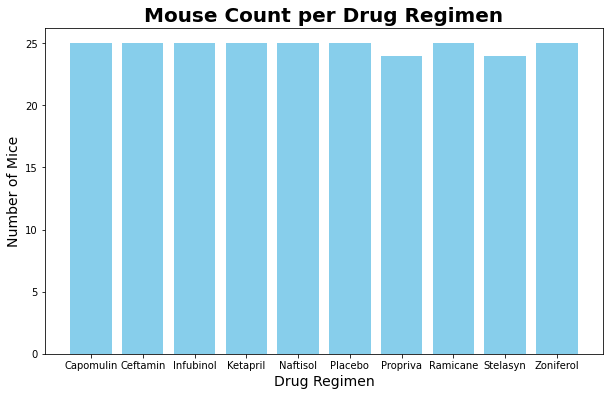

In [168]:
# Generate a bar plot showing the total number of unique mice tested on each drug regimen using pyplot.
plt.figure(figsize=(10,6))
plt.bar(mice_drugs['Drug Regimen'],mice_drugs['Number of Mice'], color="skyblue")

plt.title("Mouse Count per Drug Regimen", fontsize=20, fontweight="bold")
plt.xlabel("Drug Regimen", fontsize=14)
plt.ylabel("Number of Mice", fontsize=14)

plt.show()

<AxesSubplot:title={'center':'Mice per Drug Regimen'}, xlabel='Drug Regimen'>

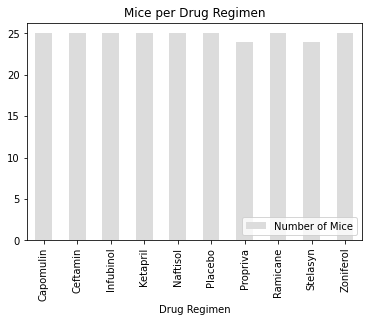

In [169]:
# Generate a bar plot showing the total number of unique mice tested on each drug regimen using pyplot.
# Generate a bar plot showing the total number of unique mice tested on each drug regimen using pandas.
panda_bar = mice_drugs.plot.bar(x='Drug Regimen',y='Number of Mice',color='gainsboro',title="Mice per Drug Regimen")
panda_bar.legend(loc=4)
panda_bar

<AxesSubplot:title={'center':'Male vs Female Mice'}, ylabel='Sex'>

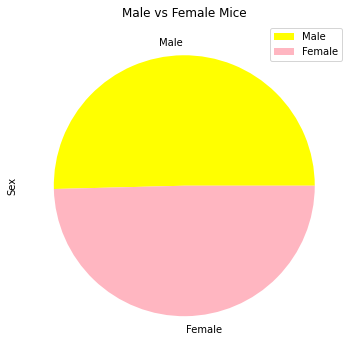

In [170]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
mice_sex = cleaned_df.loc[:,['Mouse ID','Sex']].drop_duplicates()
colors = ["yellow", "lightpink"]
sex_counts = pd.DataFrame(mice_sex.Sex.value_counts())
plot = sex_counts.plot.pie(y="Sex",figsize=(6,6),title="Male vs Female Mice",colors = colors)
plot

(-1.1879383453817902,
 1.111754351424799,
 -1.1987553745848882,
 1.1126035084692154)

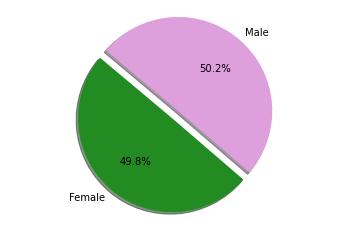

In [171]:
# # Generate a pie plot showing the distribution of female versus male mice using pyplot
# Generate a pie plot showing the distribution of female versus male mice using pyplot

labels = ["Female","Male"]


sizes = [49.799197,50.200803]

colors = ['forestgreen', 'plum']

explode = (0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=140)

#Set equal axis
plt.axis("equal")

## Quartiles, Outliers and Boxplots

In [172]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse


# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
grouped = cleaned_df.loc[cleaned_df["Drug Regimen"].isin({"Capomulin", "Ramicane", "Infubinol", "Ceftamin"})]
grouped

# Start by getting the last (greatest) timepoint for each mouse
grouped_sort = ftv_grouped.sort_values(by=["Mouse ID","Timepoint"])
grouped_sort_last = ftv_group_sort.drop_duplicates(["Mouse ID"] ,keep = "last")
grouped_sort_last.head()


,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g),MouseID_Timepoint
1804,a203,45,67.973419,2,Infubinol,Female,20,23,a203_45
1786,a251,45,65.525743,1,Infubinol,Female,21,25,a251_45
1856,a275,45,62.999356,3,Ceftamin,Female,20,28,a275_45
1773,a411,45,38.407618,1,Ramicane,Male,3,22,a411_45
1836,a444,45,43.047543,0,Ramicane,Female,10,25,a444_45


In [173]:
# Put treatments into a list for for loop (and later for plot labels)


# Create empty list to fill with tumor vol data (for plotting)


# Calculate the IQR and quantitatively determine if there are any potential outliers. 

    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    
    
    # add subset 
    
    
    # Determine outliers using upper and lower bounds

drug_regimens = grouped_sort_last["Drug Regimen"].unique()


vol_data = []

for drug in drug_regimens:
    rows = grouped_sort_last.loc[ftv_group_sort_last["Drug Regimen"] == drug]
    volumes = rows["Tumor Volume (mm3)"]
    # add subset 
    vol_data.append(volumes)
    
    Q1 = volumes.quantile(0.25)
    Q3 = volumes.quantile(0.75)
    minimum = Q1 - 1.5*(Q3 - Q1)
    maximum = Q3 + 1.5*(Q3 - Q1)
    
    outliers = volumes.loc[(volumes < minimum) | (volumes > maximum)]
    print(outliers)
    

420    36.321346
Name: Tumor Volume (mm3), dtype: float64
Series([], Name: Tumor Volume (mm3), dtype: float64)
Series([], Name: Tumor Volume (mm3), dtype: float64)
Series([], Name: Tumor Volume (mm3), dtype: float64)


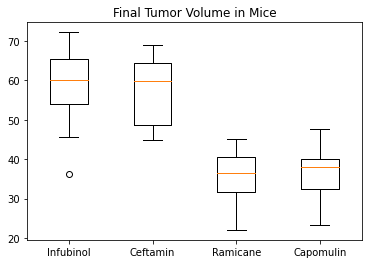

In [174]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
plt.boxplot(vol_data, labels=drug_regimens)
plt.title("Final Tumor Volume in Mice")
plt.show()

## Line and Scatter Plots

<function matplotlib.pyplot.show(close=None, block=None)>

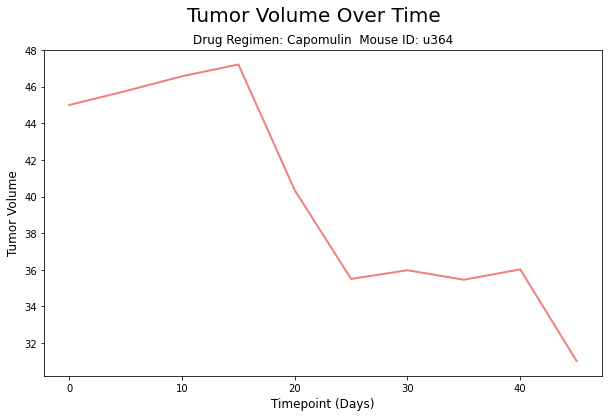

In [175]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin
capomulin = cleaned_df.loc[(cleandf['Drug Regimen'] == "Capomulin") & (cleaned_df['Mouse ID']== 'u364')]
x_axis = cap_sample['Timepoint']


plt.figure(figsize=(10,6))
plt.plot(x_axis,cap_sample['Tumor Volume (mm3)'],linewidth=2, color='lightcoral')
plt.suptitle("Tumor Volume Over Time", fontsize = 20, fontweight="regular")
plt.title("Drug Regimen: Capomulin  Mouse ID: u364", fontsize = 12)
plt.xlabel('Timepoint (Days)',fontsize=12)
plt.ylabel("Tumor Volume",fontsize=12)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

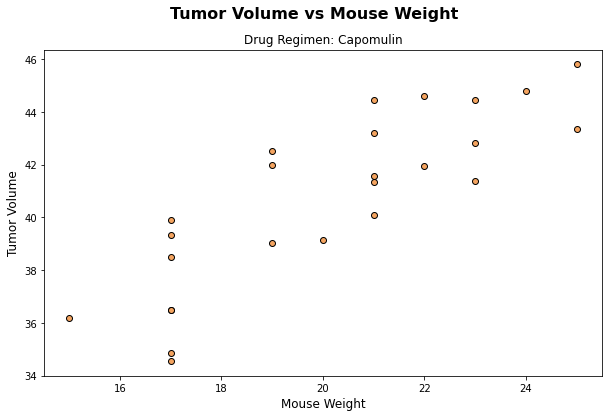

In [176]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
capomulin_sam2 = cleandf.loc[cleandf['Drug Regimen'] == "Capomulin"]
avg_tumor_vol = capomulin_sam2.groupby("Mouse ID")['Tumor Volume (mm3)'].mean()
avg_tumor_weight = capomulin_sam2.groupby("Mouse ID")['Weight (g)'].mean()

plt.figure(figsize=(10,6))
plt.scatter(avg_tumor_weight,avg_tumor_vol,marker="o", facecolors="sandybrown", edgecolors="black")
plt.suptitle("Tumor Volume vs Mouse Weight", fontsize = 16, fontweight="bold")
plt.title("Drug Regimen: Capomulin")
plt.xlabel("Mouse Weight",fontsize=12)
plt.ylabel("Tumor Volume",fontsize=12)
plt.show

## Correlation and Regression

The correlation between both factors is 0.84
The r-squared is: 0.27636002234559204
y =0.96x + 21.49


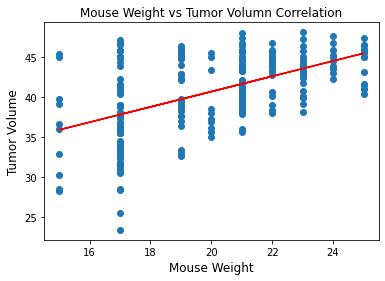

In [181]:
x_values = capomulin_sam2["Weight (g)"]
y_values = capomulin_sam2["Tumor Volume (mm3)"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y =" + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.title("Mouse Weight vs Tumor Volumn Correlation")
plt.xlabel("Mouse Weight",fontsize=12)
plt.ylabel("Tumor Volume",fontsize=12)
correlation = st.pearsonr(avg_tumor_weight,avg_tumor_vol)
print(f"The correlation between both factors is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
print(line_eq)
plt.show()